# Brain Tumor MRI Classification

#  Xception-KNN Hybrid Model

### Author: Ethan Gilles

---

## Importing libraries

In [5]:
import random
import torchvision
import torch
import torch.nn as nn
import timm
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

## Cuda drivers

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

device(type='cuda')

## Data loading

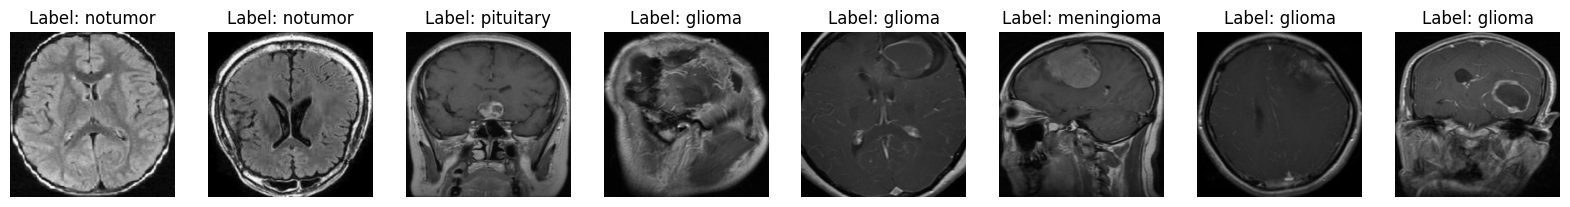

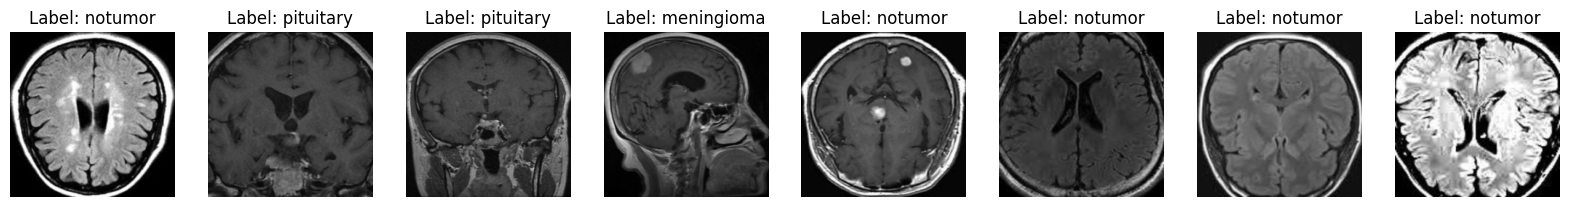

In [9]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

train_dataset = datasets.ImageFolder(root='data/training', transform=transform)
test_dataset = datasets.ImageFolder(root='data/testing', transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(20, 3))

    random_indices = random.sample(range(len(dataset)), num_images)

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Get the image and label
        image = image.numpy().transpose((1, 2, 0))  # Convert from CxHxW to HxWxC
        image = (image * 0.5) + 0.5  # Undo normalization for visualization

        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f'Label: {dataset.classes[label]}')
        plt.axis('off')

    plt.show()


visualize_images(train_dataset, num_images=8)
visualize_images(test_dataset, num_images=8)

# Create the Xception-KNN Hybrid

In [11]:
def create_feature_extractor():
    base_model = timm.create_model('xception', pretrained=True, num_classes=0)  # No final layer
    model = nn.Sequential(
        base_model,
        nn.Flatten(),
        nn.Dropout(0.3),
        nn.Linear(base_model.num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        # Remove the final classification layer (softmax)
    )
    return model.to(device)

feature_extractor = create_feature_extractor()
feature_extractor.load_state_dict(torch.load('xception_model_weights.pth'), strict=False)
feature_extractor.eval()

summary(model=feature_extractor, input_size=(32, 3, 227, 227))

/home/exan/anaconda3/lib/python3.12/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/tmp/ipykernel_3694/1004357240.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded f

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    [32, 128]                 --
├─Xception: 1-1                               [32, 2048]                --
│    └─Conv2d: 2-1                            [32, 32, 113, 113]        864
│    └─BatchNorm2d: 2-2                       [32, 32, 113, 113]        64
│    └─ReLU: 2-3                              [32, 32, 113, 113]        --
│    └─Conv2d: 2-4                            [32, 64, 111, 111]        18,432
│    └─BatchNorm2d: 2-5                       [32, 64, 111, 111]        128
│    └─ReLU: 2-6                              [32, 64, 111, 111]        --
│    └─Block: 2-7                             [32, 128, 56, 56]         --
│    │    └─Sequential: 3-1                   [32, 128, 56, 56]         26,816
│    │    └─Conv2d: 3-2                       [32, 128, 56, 56]         8,192
│    │    └─BatchNorm2d: 3-3                  [32, 128, 56, 56]         256
│    └

## Finding the optimal p-value

Running the cell takes a long time.
The optimal p value found in the range [1, 20] is 13

The differences between p values have an effect of ~0.1% on accuracy, so p = 2 was used for simplicity.

In [ ]:
# Hyperparameters
batch_size = 32
k_folds = 5
num_neighbors = 5
p_values = range(1, 21)  # p-values to test

# Define the K-Fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Lists to store average accuracies for each p-value
avg_val_accuracies = []

# Loop over different p-values
for p in p_values:
    print(f'Testing p = {p}')
    
    # Lists to store metrics for each fold
    val_accuracies = []

    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
        print(f'FOLD {fold + 1}')
        print('--------------------------------')

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = Subset(train_dataset, train_ids)
        val_subsampler = Subset(train_dataset, val_ids)

        # Define data loaders for training and validation data in this fold
        train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

        # Extract features from the training set
        train_features = []
        train_labels = []
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                features = feature_extractor(inputs)
                train_features.append(features.cpu().numpy())
                train_labels.append(labels.numpy())
        train_features = np.concatenate(train_features, axis=0)
        train_labels = np.concatenate(train_labels, axis=0)

        # Extract features from the validation set
        val_features = []
        val_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                features = feature_extractor(inputs)
                val_features.append(features.cpu().numpy())
                val_labels.append(labels.numpy())
        val_features = np.concatenate(val_features, axis=0)
        val_labels = np.concatenate(val_labels, axis=0)

        # Train KNN classifier with Minkowski distance
        knn = KNeighborsClassifier(n_neighbors=num_neighbors, p=p)
        knn.fit(train_features, train_labels)

        # Compute validation accuracy
        val_preds = knn.predict(val_features)
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_accuracy)

        print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

    # Compute average validation accuracy for this p-value
    avg_val_accuracy = np.mean(val_accuracies)
    avg_val_accuracies.append(avg_val_accuracy)
    print(f'Average Validation Accuracy for p = {p}: {avg_val_accuracy * 100:.2f}%')

# Plot the accuracy across different p-values
plt.figure(figsize=(10, 6))
plt.plot(p_values, avg_val_accuracies, marker='o')
plt.title('Validation Accuracy vs. Minkowski p-value')
plt.xlabel('Minkowski p-value')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Find the optimal p-value
optimal_p = p_values[np.argmax(avg_val_accuracies)]
print(f'Optimal Minkowski p-value: {optimal_p}')

## Finding the optimal k-value

Running the cell takes a long time.
The optimal k value found in the range [1, 11] is 7

The differences between k values have an effect of ~0.1% on accuracy, so k = 5 was used for simplicity.

In [ ]:
# Hyperparameters
batch_size = 32
k_folds = 5
p_value = 2 
k_values = range(1, 12)  # Range of k-values to test

# Define the K-Fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Lists to store average accuracies for each k-value
avg_val_accuracies = []

# Loop over different k-values
for k in k_values:
    print(f'Testing k = {k}')
    
    # Lists to store metrics for each fold
    val_accuracies = []

    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
        print(f'FOLD {fold + 1}')
        print('--------------------------------')

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = Subset(train_dataset, train_ids)
        val_subsampler = Subset(train_dataset, val_ids)

        # Define data loaders for training and validation data in this fold
        train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

        # Extract features from the training set
        train_features = []
        train_labels = []
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                features = feature_extractor(inputs)
                train_features.append(features.cpu().numpy())
                train_labels.append(labels.numpy())
        train_features = np.concatenate(train_features, axis=0)
        train_labels = np.concatenate(train_labels, axis=0)

        # Extract features from the validation set
        val_features = []
        val_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                features = feature_extractor(inputs)
                val_features.append(features.cpu().numpy())
                val_labels.append(labels.numpy())
        val_features = np.concatenate(val_features, axis=0)
        val_labels = np.concatenate(val_labels, axis=0)

        # Train KNN classifier with current k-value
        knn = KNeighborsClassifier(n_neighbors=k, p=p_value)
        knn.fit(train_features, train_labels)

        # Compute validation accuracy
        val_preds = knn.predict(val_features)
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_accuracy)

        print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

    # Compute average validation accuracy for this k-value
    avg_val_accuracy = np.mean(val_accuracies)
    avg_val_accuracies.append(avg_val_accuracy)
    print(f'Average Validation Accuracy for k = {k}: {avg_val_accuracy * 100:.2f}%')

# Plot the accuracy across different k-values
plt.figure(figsize=(10, 6))
plt.plot(k_values, avg_val_accuracies, marker='o')
plt.title('Validation Accuracy vs. k-value')
plt.xlabel('k-value (Number of Neighbors)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

# Find the optimal k-value
optimal_k = k_values[np.argmax(avg_val_accuracies)]
print(f'Optimal k-value: {optimal_k}')

## K-Fold Cross Validation Training

5 folds with a batch size of 32

In [16]:
# Hyperparameters
batch_size = 32
k_folds = 5
num_neighbors = 5
minkowski_p = 2

# Define the K-Fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Lists to store metrics for each fold
train_accuracies = []
val_accuracies = []
class_reports = []
class_names = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f'FOLD {fold + 1}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(train_dataset, train_ids)
    val_subsampler = Subset(train_dataset, val_ids)

    # Define data loaders for training and validation data in this fold
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Extract features from the training set
    train_features = []
    train_labels = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            features = feature_extractor(inputs)
            train_features.append(features.cpu().numpy())
            train_labels.append(labels.numpy())
    train_features = np.concatenate(train_features, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # Extract features from the validation set
    val_features = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            features = feature_extractor(inputs)
            val_features.append(features.cpu().numpy())
            val_labels.append(labels.numpy())
    val_features = np.concatenate(val_features, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)

    # Train KNN classifier with Minkowski distance
    knn = KNeighborsClassifier(n_neighbors=num_neighbors, p=minkowski_p)
    knn.fit(train_features, train_labels)

    # Compute training accuracy
    train_preds = knn.predict(train_features)
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_accuracy)
    
    # Compute validation accuracy
    val_preds = knn.predict(val_features)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_accuracy)

    # Store classification report for this fold
    class_reports.append(classification_report(val_labels, val_preds, output_dict=True))

    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Compute macro and weighted averages
macro_accuracy_avg = np.mean(train_accuracies + val_accuracies)
weighted_accuracy_avg = np.average(
    train_accuracies + val_accuracies,
    weights=[len(train_ids)] * k_folds + [len(val_ids)] * k_folds
)

# Print final metrics
print('\nFinal Metrics:')
print(f'Training Accuracy (Avg): {np.mean(train_accuracies) * 100:.2f}%')
print(f'Validation Accuracy (Avg): {np.mean(val_accuracies) * 100:.2f}%')
print(f'Macro Accuracy Avg: {macro_accuracy_avg * 100:.2f}%')
print(f'Weighted Accuracy Avg: {weighted_accuracy_avg * 100:.2f}%')

print("\nClassification Report for Last Fold:")
print(classification_report(val_labels, val_preds, target_names=class_names))

print('Finished Cross-Validation')

FOLD 1
--------------------------------
Training Accuracy: 99.58%
Validation Accuracy: 100.00%
FOLD 2
--------------------------------
Training Accuracy: 99.63%
Validation Accuracy: 99.74%
FOLD 3
--------------------------------
Training Accuracy: 99.67%
Validation Accuracy: 99.74%
FOLD 4
--------------------------------
Training Accuracy: 99.80%
Validation Accuracy: 98.95%
FOLD 5
--------------------------------
Training Accuracy: 99.58%
Validation Accuracy: 99.74%

Final Metrics:
Training Accuracy (Avg): 99.65%
Validation Accuracy (Avg): 99.63%
Macro Accuracy Avg: 99.64%
Weighted Accuracy Avg: 99.65%

Classification Report for Last Fold:
              precision    recall  f1-score   support

      Glioma       1.00      1.00      1.00       258
  Meningioma       1.00      1.00      1.00       278
    No Tumor       1.00      0.99      1.00       324
   Pituitary       1.00      1.00      1.00       282

    accuracy                           1.00      1142
   macro avg       1.00   

## Testing XcepKNN

In [18]:
from tabulate import tabulate  

# Extract features from the test set
test_features = []
test_labels = []
feature_extractor.eval()
with torch.no_grad():
    for inputs, labels in DataLoader(test_dataset, batch_size=batch_size, shuffle=False):
        inputs = inputs.to(device)
        features = feature_extractor(inputs)
        test_features.append(features.cpu().numpy())
        test_labels.append(labels.numpy())

test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Make predictions on the test set
test_preds = knn.predict(test_features)

# Compute metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision_weighted = precision_score(test_labels, test_preds, average='weighted')
test_recall_weighted = recall_score(test_labels, test_preds, average='weighted')
test_f1_weighted = f1_score(test_labels, test_preds, average='weighted')
test_precision_macro = precision_score(test_labels, test_preds, average='macro')
test_recall_macro = recall_score(test_labels, test_preds, average='macro')
test_f1_macro = f1_score(test_labels, test_preds, average='macro')

# Get classification report
class_report = classification_report(test_labels, test_preds, output_dict=True, target_names=class_names)

# Extract per-class statistics
class_stats = []
for class_name in class_report.keys():
    if class_name in ['macro avg', 'weighted avg', 'accuracy']:
        continue
    class_stats.append([
        class_name,
        round(class_report[class_name]['precision'], 4),
        round(class_report[class_name]['recall'], 4),
        round(class_report[class_name]['f1-score'], 4),
        int(class_report[class_name]['support']),  # Support is an integer
    ])

# Add macro and weighted averages
class_stats.append([
    "Testing Macro Avg",
    round(test_precision_macro, 4),
    round(test_recall_macro, 4),
    round(test_f1_macro, 4),
    int(class_report['macro avg']['support']),  # Support is an integer
])
class_stats.append([
    "Testing Weighted Avg",
    round(test_precision_weighted, 4),
    round(test_recall_weighted, 4),
    round(test_f1_weighted, 4),
    int(class_report['weighted avg']['support']),  # Support is an integer
])

# Add overall test performance metrics
class_stats.append([
    "Testing Overall Metrics",
    round(test_precision_weighted, 4),
    round(test_recall_weighted, 4),
    round(test_f1_weighted, 4),
    len(test_labels),  # Total number of test samples
])

# Print the table with four decimal places
headers = ["Class", "Precision", "Recall", "F1 Score", "Support"]
print(tabulate(class_stats, headers=headers, tablefmt="grid", floatfmt=".4f"))

# Print additional metrics (if needed)
print(f"Test Accuracy: {test_accuracy:.4f}") 
print(f"Macro Accuracy Avg: {test_precision_macro:.4f}") 
print(f"Weighted Accuracy Avg: {test_precision_weighted:.4f}") 

+-------------------------+-------------+----------+------------+-----------+
| Class                   |   Precision |   Recall |   F1 Score |   Support |
+=========================+=============+==========+============+===========+
| Glioma                  |      0.9739 |   0.9868 |     0.9803 |       303 |
+-------------------------+-------------+----------+------------+-----------+
| Meningioma              |      0.9866 |   0.9608 |     0.9735 |       306 |
+-------------------------+-------------+----------+------------+-----------+
| No Tumor                |      0.9901 |   0.9901 |     0.9901 |       405 |
+-------------------------+-------------+----------+------------+-----------+
| Pituitary               |      0.9836 |   0.9967 |     0.9901 |       300 |
+-------------------------+-------------+----------+------------+-----------+
| Testing Macro Avg       |      0.9835 |   0.9836 |     0.9835 |      1314 |
+-------------------------+-------------+----------+------------

## Confusion Matrix

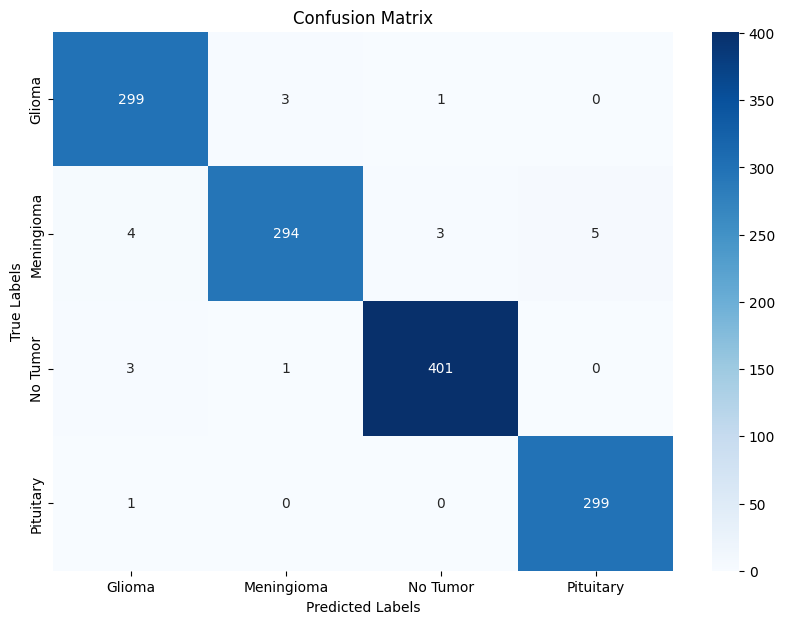

In [20]:
import seaborn as sns
# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()